<a href="https://colab.research.google.com/github/rehan363/lang_chain/blob/main/2_2_chains_reducers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%%capture --no-stderr
%pip install --quiet -U langchain_core langgraph  langchain-google-genai


In [2]:
from langchain_core.messages import HumanMessage, AIMessage, SystemMessage

# **Chat Models**

In [3]:
from google.colab import userdata

gemini_api_key = userdata.get('GOOGLE_API_KEY')

In [4]:
!pip install --quiet -U langchain-google-genai
from langchain_google_genai import ChatGoogleGenerativeAI

llm= ChatGoogleGenerativeAI(
    model= "gemini-1.5-flash",
    api_key= gemini_api_key,

)
result= llm.invoke("hello")


In [ ]:
result

AIMessage(content='Hello there! How can I help you today?\n', additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': []}, id='run-6fb25d40-f548-4850-ad05-92d69073b787-0', usage_metadata={'input_tokens': 2, 'output_tokens': 11, 'total_tokens': 13, 'input_token_details': {'cache_read': 0}})

In [ ]:
result.response_metadata

{'prompt_feedback': {'block_reason': 0, 'safety_ratings': []},
 'finish_reason': 'STOP',
 'safety_ratings': []}

***Tools***

In [23]:
def multiply(a: int, b:int) ->int:
  """multiply a and b
  Args:
    a: first integer
    b: secound integer
    """
  return a * b

llm_with_tools: ChatGoogleGenerativeAI = llm.bind_tools([multiply])

In [6]:
function_call = llm_with_tools.invoke([HumanMessage(content="what is 2 multiply with 3", name="Rehan")])
function_call

AIMessage(content='', additional_kwargs={'function_call': {'name': 'multiply', 'arguments': '{"a": 2.0, "b": 3.0}'}}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': []}, id='run-642368ed-f73b-495d-a947-4f63a20949f6-0', tool_calls=[{'name': 'multiply', 'args': {'a': 2.0, 'b': 3.0}, 'id': 'b2f8a77a-eb06-42e1-bfd1-8be31c41b4a5', 'type': 'tool_call'}], usage_metadata={'input_tokens': 70, 'output_tokens': 3, 'total_tokens': 73, 'input_token_details': {'cache_read': 0}})

In [15]:
function_call.additional_kwargs['function_call']

{'name': 'multiply', 'arguments': '{"a": 2.0, "b": 3.0}'}

**REDUCER FUNCTION**

In [7]:
from typing import Annotated
from typing import TypedDict
from langchain_core.messages import AnyMessage
from langgraph.graph.message import add_messages

class MessageState(TypedDict):

  messages: Annotated[list[AnyMessage], add_messages]


LangGraph has a pre-built MessagesState!


***MessagesState*** is defined:

1.With a pre-build single **messages** key

2.This is a list of ***AnyMessage*** objects

3.It uses the ***add_messages*** reducer

In [8]:
from langgraph.graph import MessagesState

class MessageConversationalState(MessagesState):
  #add any key beyond which is needed
  pass

now we have to check weather add_messages is working or not.

In [9]:
#initial state

initial_state= [AIMessage(content="hello! how can i help you.",name="Model"),
                HumanMessage(content="how we can develop AI agents",name="Rehan")]

#new message to add
new_message= [AIMessage(content="are you a fresh person in AI",name="Rehan")]

add_messages(initial_state, new_message)

[AIMessage(content='hello! how can i help you.', additional_kwargs={}, response_metadata={}, name='Model', id='a1b70a5e-02de-49ac-9487-a75509bb3797'),
 HumanMessage(content='how we can develop AI agents', additional_kwargs={}, response_metadata={}, name='Rehan', id='b069d9dd-3a9d-4d08-a059-ebaea9a0947a'),
 AIMessage(content='are you a fresh person in AI', additional_kwargs={}, response_metadata={}, name='Rehan', id='697e43ad-a10a-4942-8b20-e2ee54b97263')]

our Graph

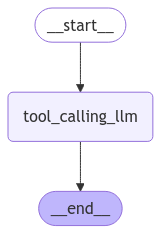

In [13]:
from IPython.display import Image,  display
from langgraph.graph.state import CompiledStateGraph
from langgraph.graph import StateGraph, START, END

#node

def tool_calling_llm(state: MessageConversationalState):
  return{"messages": [llm_with_tools.invoke(state["messages"])]}

#build_graph

builder: StateGraph = StateGraph(MessageConversationalState)
#creating nodes:
builder.add_node("tool_calling_llm", tool_calling_llm)
#creating edges:
builder.add_edge(START, "tool_calling_llm")
builder.add_edge("tool_calling_llm", END)
#graph compilation
graph: CompiledStateGraph = builder.compile()

#view
display(Image(graph.get_graph().draw_mermaid_png()))


In [31]:
from pprint import pprint
messages = graph.invoke({"messages": HumanMessage(content="Helloo!")})
pprint(messages)

{'messages': [HumanMessage(content='Helloo!', additional_kwargs={}, response_metadata={}, id='2c8cd8b0-3bb7-4e6c-86cf-4bd8f9387875'),
              AIMessage(content='Hello! How can I help you today?\n', additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': []}, id='run-72f1365b-c9f4-4bba-8f92-ffbc9644ba67-0', usage_metadata={'input_tokens': 65, 'output_tokens': 10, 'total_tokens': 75, 'input_token_details': {'cache_read': 0}})]}


In [29]:
messages= graph.invoke({"messages": HumanMessage(content= "multiply 4 and 2")})

for m in messages['messages']:
  m.pretty_print()

================================ Human Message =================================

multiply 4 and 2
================================== Ai Message ==================================
Tool Calls:
  multiply (7f42fe5d-8729-4449-8b6a-81465901e849)
 Call ID: 7f42fe5d-8729-4449-8b6a-81465901e849
  Args:
    a: 4.0
    b: 2.0
